In [3]:
%%capture
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Dataset

In [4]:
df = pd.read_csv('balanced_dataset.csv')
df.head()

,class,tweet
0,0,queer gaywad
1,0,alsarabsss hes beaner smh tell hes mexican
2,0,youre fucking gay blacklisted hoe holding tehg...
3,0,lmfaoooo hate black people theres black people...
4,0,least im nigger lmfao


## Split Data

In [5]:
features = df['tweet']
target = df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
												target,
												test_size=0.2,
												random_state=22)
X_train.shape, X_val.shape

# make labels categorical
Y_train = to_categorical(Y_train, num_classes=3)
Y_val = to_categorical(Y_val, num_classes=3)

## Tokenization

In [6]:
with open('tokenizer.pkl', 'rb') as handle:
    token = pickle.load(handle)

In [7]:
# generating token embeddings
max_words = 5000
max_len = 100

X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len)

## Model

In [8]:
model = keras.models.Sequential([
        layers.Embedding(max_words, 32, input_length=max_words),
        layers.Conv1D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(),
        layers.Flatten(),
        layers.Dense(250, activation='relu'),
        layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

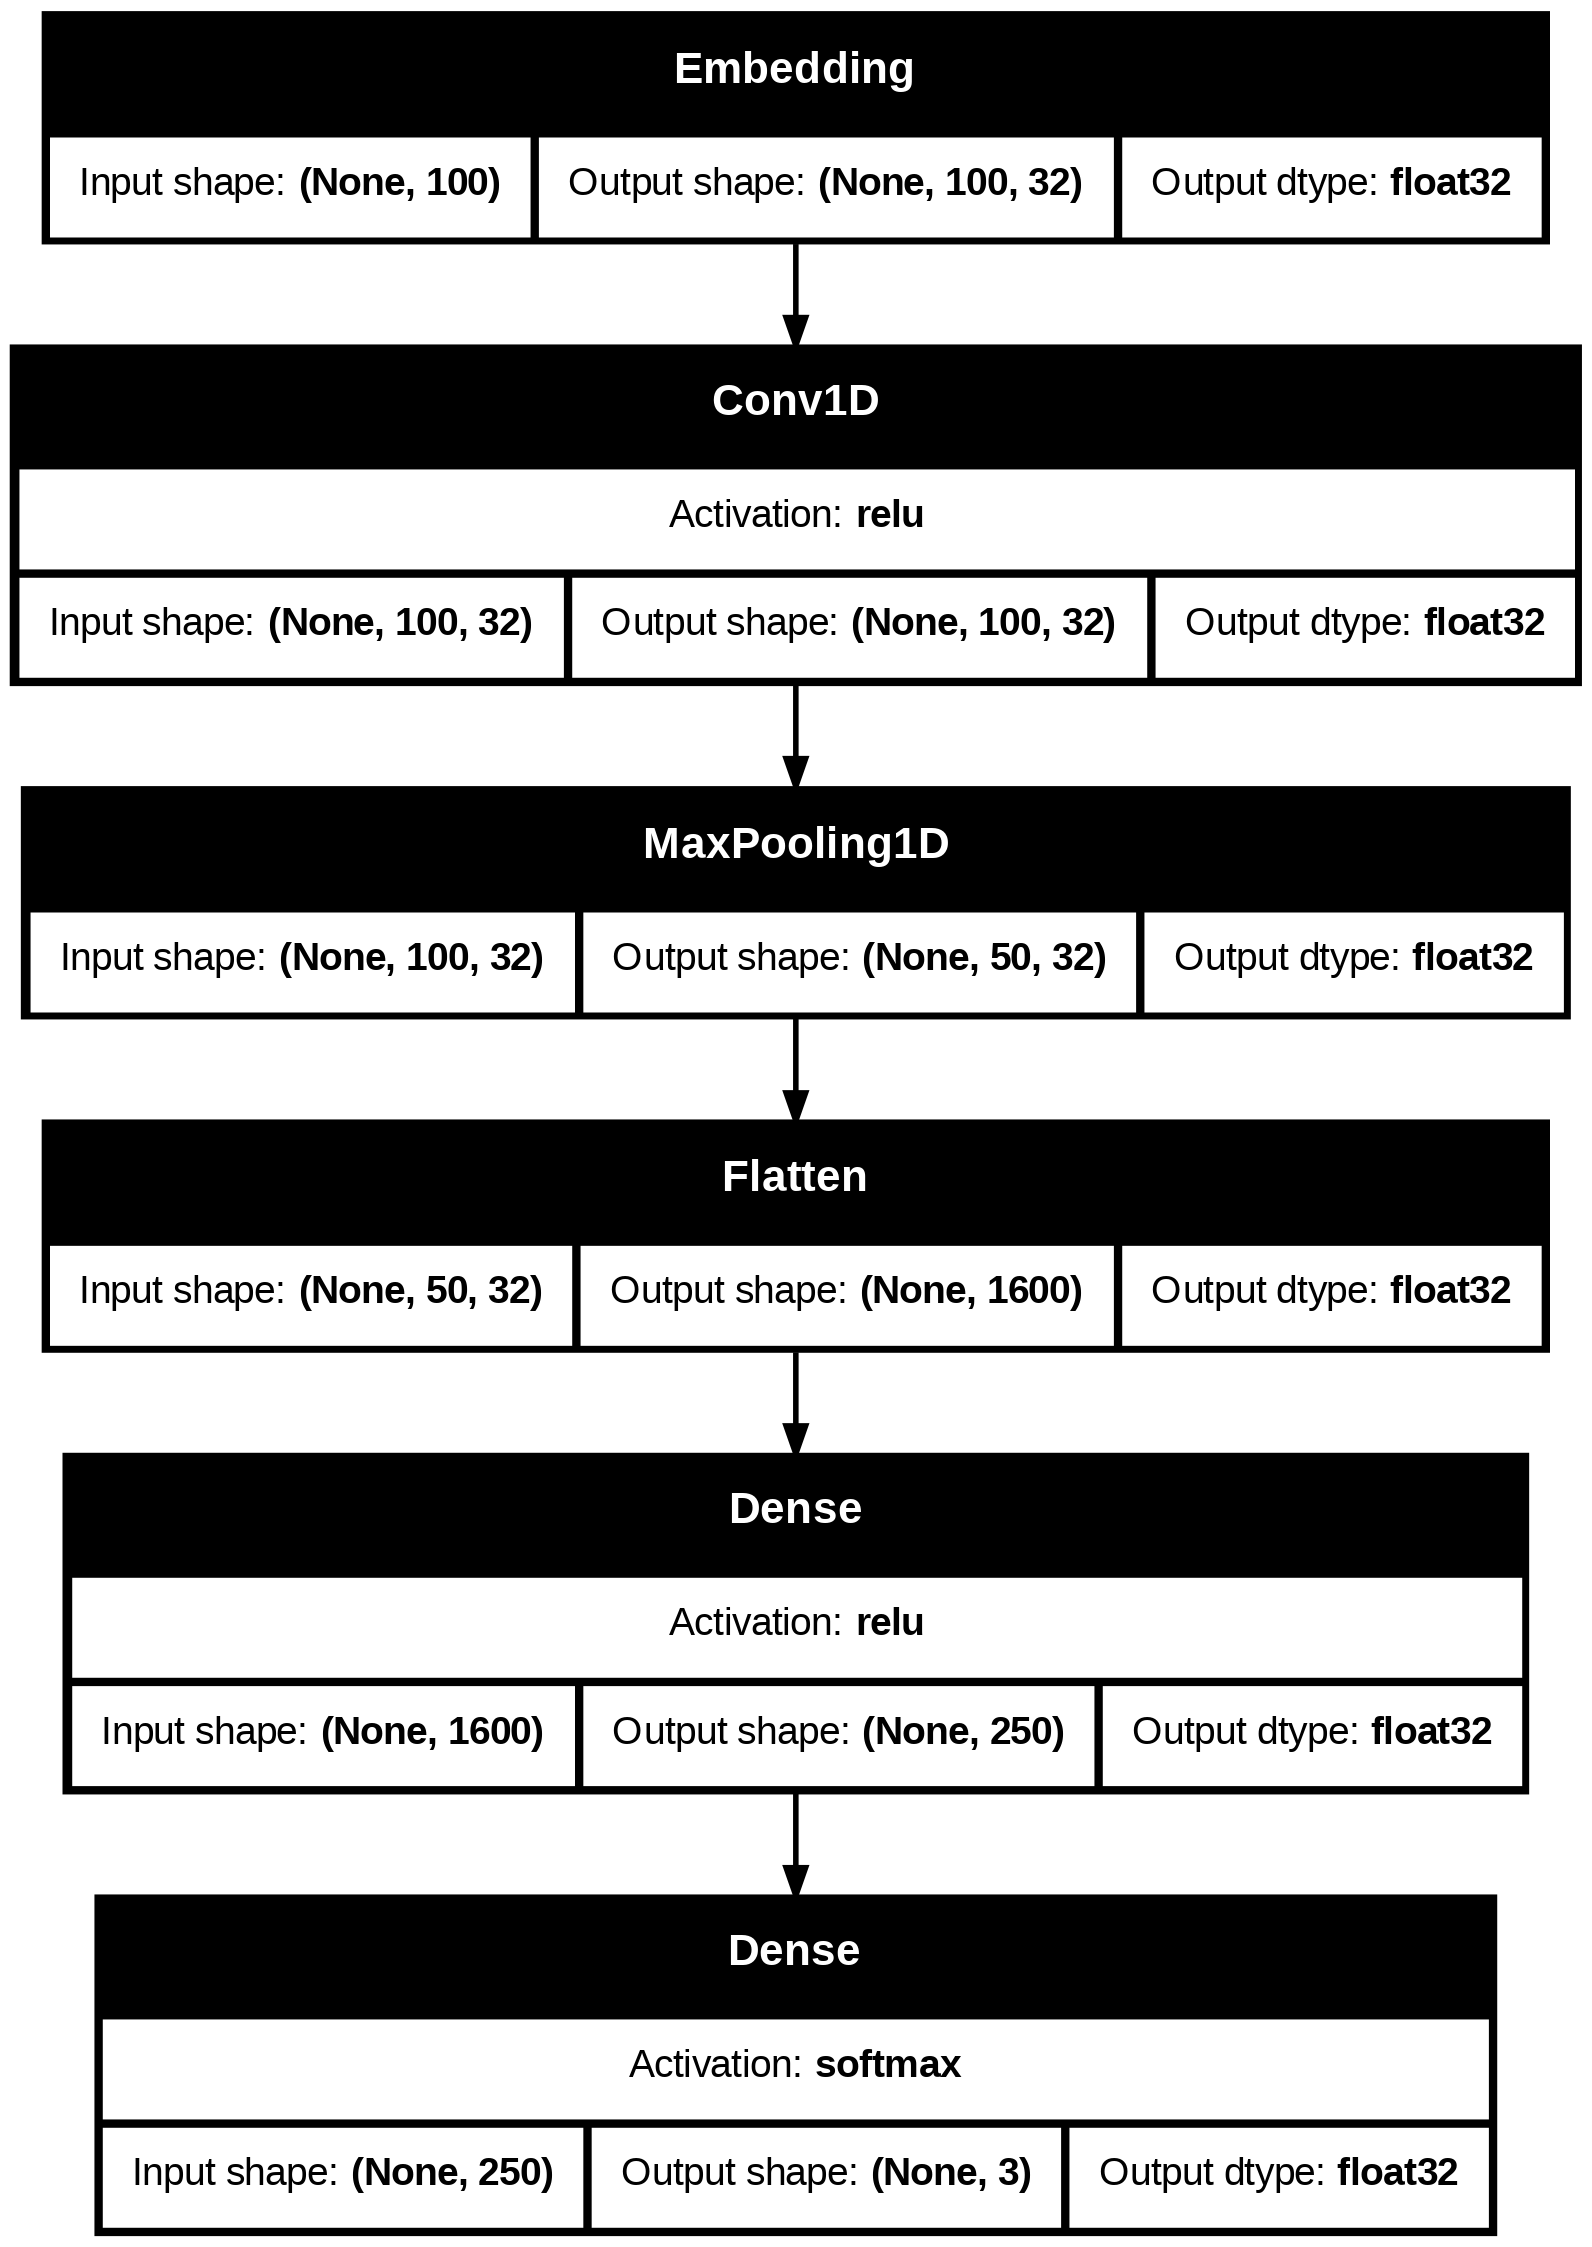

In [9]:
# Add a dummy input to build the model
model.build((None, max_len))

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [10]:
lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)

In [11]:
# custom callback to calculate precision, recall, and F1-score
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predictions = np.argmax(self.model.predict(X_val_padded), axis=1)
        val_true = np.argmax(Y_val, axis=1)

        precision = precision_score(val_true, val_predictions, average='weighted')
        recall = recall_score(val_true, val_predictions, average='weighted')
        f1 = f1_score(val_true, val_predictions, average='weighted')

        print(f" - val_precision: {precision:.4f} - val_recall: {recall:.4f} - val_f1_score: {f1:.4f}")
        logs.update({'val_precision': precision, 'val_recall': recall, 'val_f1_score': f1})

In [12]:
metrics_callback = MetricsCallback()

history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=128,
                    verbose=2,
                    callbacks=[lr, metrics_callback])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 - val_precision: 0.7743 - val_recall: 0.7771 - val_f1_score: 0.7735
75/75 - 4s - 55ms/step - accuracy: 0.5625 - loss: 0.9185 - val_accuracy: 0.7771 - val_loss: 0.5754 - learning_rate: 0.0010 - val_precision: 0.7743 - val_recall: 0.7771 - val_f1_score: 0.7735
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 - val_precision: 0.8603 - val_recall: 0.8611 - val_f1_score: 0.8606
75/75 - 3s - 40ms/step - accuracy: 0.8692 - loss: 0.3644 - val_accuracy: 0.8611 - val_loss: 0.3731 - learning_rate: 0.0010 - val_precision: 0.8603 - val_recall: 0.8611 - val_f1_score: 0.8606
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 - val_precision: 0.8834 - val_recall: 0.8833 - val_f1_score: 0.8828
75/75 - 4s - 58ms/step - accuracy: 0.9384 - loss: 0.1873 - val_accuracy: 0.8833 - val_loss: 0.3294 - learning_rate: 0.0010 - val_precision: 0.8834 - val_recall: 0.8833 - val_f1_score: 0.8828
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 - val_precision: 0.

## Visualize Model Results

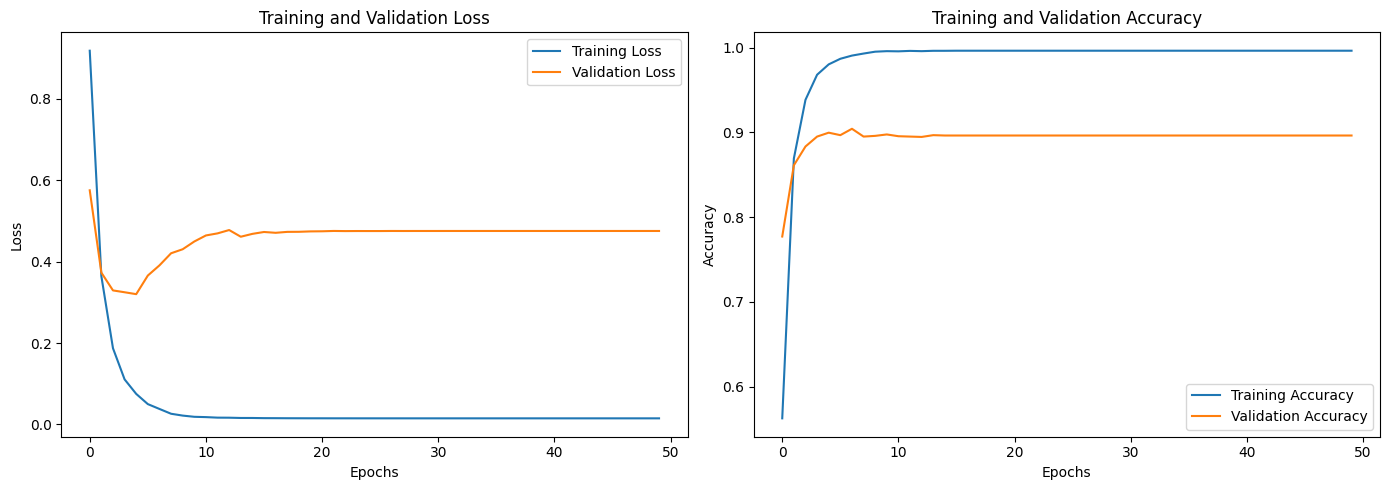

In [13]:
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot loss
history_df.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(['Training Loss', 'Validation Loss'])

# plot accuracy
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout()
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


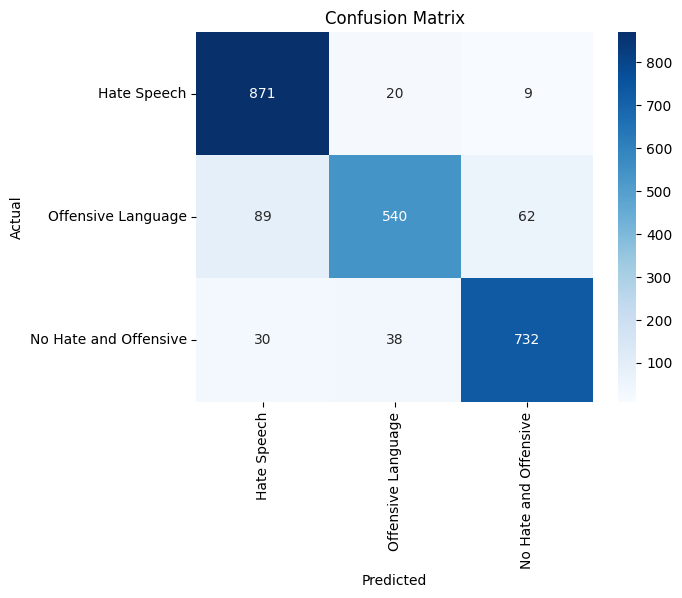

In [14]:
pred = model.predict(X_val_padded)
pred_class = np.argmax(pred, axis=1)

# plot the confusion matrix
Y_val_class = np.argmax(Y_val, axis=1)
conf_matrix = confusion_matrix(Y_val_class, pred_class)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate Speech', 'Offensive Language', 'No Hate and Offensive'],
            yticklabels=['Hate Speech', 'Offensive Language', 'No Hate and Offensive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
print("Classification Report:\n")
print(classification_report(Y_val_class, pred_class))

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       900
           1       0.90      0.78      0.84       691
           2       0.91      0.92      0.91       800

    accuracy                           0.90      2391
   macro avg       0.90      0.89      0.89      2391
weighted avg       0.90      0.90      0.89      2391



In [16]:
# look at the misclassified tweets

pred_df = pd.DataFrame(pred_class, columns=['pred_class'])
pred_df['actual_class'] = np.argmax(Y_val, axis=1)
pred_df['tweet'] = X_val.values

misclassified_tweets = pred_df[pred_df['pred_class'] != pred_df['actual_class']]
misclassified_tweets.head()

,pred_class,actual_class,tweet
11,0,1,release nudes cunt
35,0,1,side bitches basically new relationships staed...
58,2,1,white trash morons offended redskins team name...
60,2,0,washing coon hair
71,0,1,never trust nicca volunteers another man info


## Save Model

In [17]:
model.save('cnn.keras')